# Speech Recognition Project

In this machine learning project, I aim to tackle the task of speech recognition, specifically identifying the speaker from audio recordings. The dataset used for this project is sourced from Mozilla's Common Voice Project, a publicly available repository of voice recordings contributed by volunteers worldwide. Leveraging deep learning techniques, particularly Long Short-Term Memory (LSTM) layers, our goal is to develop a robust model capable of accurately recognizing speakers from their voice samples.

My approach involves extracting two distinct representations of the audio data: mel-spectrograms and Mel-Frequency Cepstral Coefficients (MFCCs). These representations provide valuable insights into the frequency and temporal characteristics of the audio signals, enabling the model to capture essential features for speaker identification. By training the model on both mel-spectrograms and MFCCs separately, we aim to explore the effectiveness of each representation and identify the most suitable approach for our task.

Through this project, we endeavor to contribute to advancements in speech recognition technology, with potential applications in various domains such as security, authentication, and personalized user experiences. By using deep learning techniques and rich datasets like Mozilla's Common Voice Project, I strive to develop models that exhibit robust performance and scalability in real-world scenarios.

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import librosa
import os
import pickle
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import kurtosis

from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Flatten, Reshape, TimeDistributed, GlobalAveragePooling2D,GlobalAveragePooling1D, Bidirectional
    
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# from google.colab import drive
# drive.mount('/content/drive')
warnings.filterwarnings('ignore')

## Dataset

In [19]:
# mp3 files
clips = 'common_voice/en/clips'

# TSV datasets linked to the audio files
clip_durations = 'common_voice/en/clip_durations.tsv'
other = 'common_voice/en/other.tsv'

In [41]:
durations_df = pd.read_csv(clip_durations, sep = '\t')
other_df = pd.read_csv(other, sep = '\t')

In [43]:
clips_number = len(os.listdir(clips))
clips_number
unique_speakers = other_df['client_id'].unique() 
print(f'Clips number: {clips_number}')
print(f'Unique speakers: {len(unique_speakers)}')

Clips number: 53654
Unique speakers: 1654


In [23]:
# Label encode the target which is 'client_id'
le = LabelEncoder()
other_df['target'] = le.fit_transform(other_df['client_id'])

In [24]:
# Join other_df with durations_df
other_df = other_df.merge(durations_df, how = 'inner', left_on = 'path', right_on = 'clip')
other_df = other_df.drop('clip', axis = 1)

In [26]:
#number of samples per target
value_counts = other_df['target'].value_counts()

# targets > 1000 datapoints
targets = np.array(value_counts[value_counts > 1000].index)

# Datapoints to be used in the model
model_df = other_df.loc[other_df['target'].isin(targets)]

model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22114 entries, 122 to 42781
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   client_id     22114 non-null  object 
 1   path          22114 non-null  object 
 2   sentence      22114 non-null  object 
 3   up_votes      22114 non-null  int64  
 4   down_votes    22114 non-null  int64  
 5   age           22114 non-null  object 
 6   gender        22114 non-null  object 
 7   accents       22114 non-null  object 
 8   variant       0 non-null      float64
 9   locale        22114 non-null  object 
 10  segment       0 non-null      float64
 11  target        22114 non-null  int64  
 12  duration[ms]  22114 non-null  int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 2.4+ MB


## Determining ideal length to clip or extend audio files 

The mean length of clips is around 7 seconds. I'll use that duration to clip the audio files or zero-pad them if needed to standardize audio length

Mean duration (ms): 6454.018268969883


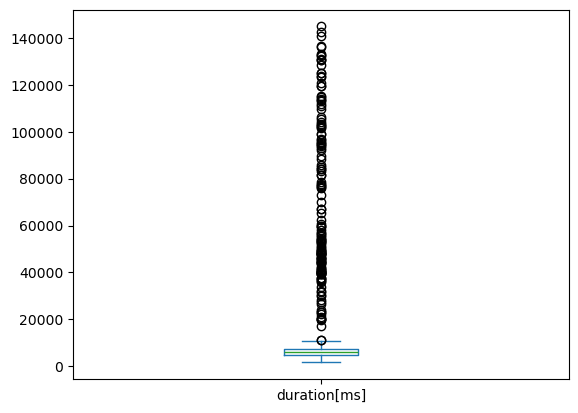

In [29]:
seconds = model_df['duration[ms]']
seconds.plot(kind = 'box');
print(f'Mean duration (ms): {seconds.mean()}')

# Mel-Spectrograms 

## Preprocessing Functions 

In [31]:
# Normalizing the matrices
def matrix_standard_scaler(matrix):
    mean = matrix.mean()
    std = matrix.std()
    if std == 0:
        std = 1e-8
    norm_matrix = (matrix - mean) / std
    return norm_matrix

In [32]:
# Gets audio file path and returns a normalized mel-spectrogram 7 seconds long
# Mel spectrogram is zero-padded or clipped if necessary
def load_and_preprocess_audio(audio_path, target_duration=7):
    # Load audio file
    audio, sr = librosa.load(audio_path, sr=None)

    # Clip or zero-pad audio to match target duration
    if len(audio) > sr * target_duration:
        # Clip audio to target duration
        audio = audio[:sr * target_duration]
    elif len(audio) < sr * target_duration:
        # Zero-pad audio to target duration
        pad_width = sr * target_duration - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')

        # Define the replacement value (in dB)
        replacement_value = -80

        # Find indices of non-zero values
        non_zero_indices = audio != 0

        # Replace zeros with the chosen value
        audio[~non_zero_indices] = replacement_value

    # Extract Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, hop_length = 2000)
    norm_ms = matrix_standard_scaler(mel_spectrogram)

    return norm_ms


audio_path = clips + "/" + os.listdir(clips)[4]
mel_spectrogram = load_and_preprocess_audio(audio_path)

# Check shape of the Mel spectrogram
print("Mel spectrogram shape:", mel_spectrogram.shape)


Mel spectrogram shape: (128, 113)


In [33]:
# Function to pickle X and y
# X is spectrograms, y is target

def pickle_sgrams(X, y, new_file_name):
    # Path to access audio files
    full_paths = clips + '/' + X
    # Extract mel-spectrograms and preprocess them
    mel_sgrams = full_paths.apply(lambda x: load_and_preprocess_audio(x))
    # Pickle files as (X, y) tuples
    with open(new_file_name, 'wb') as f:
        pickle.dump((mel_sgrams, y), f)
    return

## Train/test split of the DataFrame

In [239]:
X = model_df['path']
y = model_df['target']
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, stratify = y_trainval, random_state = 42)

def pickle_sgrams(X, y, new_file_name):
    # Path to access audio files
    full_paths = clips + '/' + X
    # Extract mel-spectrograms and preprocess them
    mel_sgrams = full_paths.apply(lambda x: load_and_preprocess_audio(x))
    # Pickle files as (X, y) tuples
    with open(new_file_name, 'wb') as f:
        pickle.dump((mel_sgrams, y), f)
    return


## Pickling train, test, and validation set

In [240]:
pickle_sgrams(X_train, y_train, 'train_set.pkl')
pickle_sgrams(X_test, y_test, 'test_set.pkl')
pickle_sgrams(X_val, y_val, 'validation_set.pkl')

### LSTM Network 
mel-sgram shape: 128 x 113

In [34]:
def lstm_network(num_classes):
    
    model = Sequential()

    model.add(LSTM(units=64, input_shape=(128, 113), return_sequences=True))
    
    model.add(GlobalAveragePooling1D()) 

    model.add(Flatten())
    
    model.add(Dense(64, activation = 'relu'))

    model.add(Dropout(0.4))

    # Output layer
    model.add(Dense(units=num_classes, activation='softmax'))

    return model
              
lstm_model = lstm_network(10)

checkpoint_filepath = 'checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
              
# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lstm_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 128, 64)           45568     
                                                                 
 global_average_pooling1d_7  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 flatten_8 (Flatten)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 10)                650       
                                                      

## Training

In [ ]:
with open('train_set.pkl', 'rb') as f:
    training_data = pickle.load(f)

    X_train, y_train = training_data
    ohe = OneHotEncoder(sparse_output = False)
    y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1))

    # Stack matrices into a single tensor
    X_train = np.stack(X_train)

    # Reshape the stacked tensor to remove outer dimensions
    X_train = X_train.reshape(-1, *X_train[0].shape)

with open('validation_set.pkl', 'rb') as f_2:
        validation_data = pickle.load(f_2)
        x_val, y_val = validation_data



lstm_model.fit(X_train,
               y_train,
               epochs = 100,
               callbacks = model_checkpoint_callback,
              validation_split = 0.2)

# MFCCs EDA

In [45]:
def get_mfcc(audio_path:str, target_duration = 7):
    # Load audio file
    audio, sr = librosa.load(audio_path, sr=None)

    # Clip or zero-pad audio to match target duration
    if len(audio) > sr * target_duration:
        # Clip audio to target duration
        audio = audio[:sr * target_duration]
    elif len(audio) < sr * target_duration:
        # Zero-pad audio to target duration
        pad_width = sr * target_duration - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')

        # Define the replacement value (in dB)
        replacement_value = -80

        # Find indices of non-zero values
        non_zero_indices = audio != 0

        # Replace zeros with the chosen value
        audio[~non_zero_indices] = replacement_value

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, hop_length = 2000)
    norm_mfccs = matrix_standard_scaler(mfccs)

    return norm_mfccs

### Extract MFCCs 

In [47]:
mfccs = model_df['path'].apply(lambda x: get_mfcc(clips + '/' + x))

In [57]:
mfccs_df = pd.concat([mfccs, model_df['target']], axis = 1, join = 'inner')

In [59]:
mfccs_df = mfccs_df.rename(columns = {'path': 'mfccs'})

### Extract Delta and Delta 2

In [63]:
mfccs_df['delta'] = mfccs_df['mfccs'].apply(lambda x: librosa.feature.delta(x, mode = 'wrap'))

mfccs_df['delta_2'] = mfccs_df['mfccs'].apply(lambda x: librosa.feature.delta(x, order = 2, mode = 'wrap'))

In [73]:
#MFCCs aggregate features
mfccs_df['mfccs_mean'] = mfccs_df['mfccs'].apply(lambda x: x.mean())
mfccs_df['mfccs_std'] = mfccs_df['mfccs'].apply(lambda x: x.std())
mfccs_df['mfccs_max'] = mfccs_df['mfccs'].apply(lambda x: x.max())
mfccs_df['mfccs_min'] = mfccs_df['mfccs'].apply(lambda x: x.min())
mfccs_df['mfccs_q1'] = mfccs_df['mfccs'].apply(lambda x: np.quantile(x, 0.25))
mfccs_df['mfccs_q2'] = mfccs_df['mfccs'].apply(lambda x: np.quantile(x, 0.5))
mfccs_df['mfccs_q3'] = mfccs_df['mfccs'].apply(lambda x: np.quantile(x, 0.75))

#MFCCs Delta aggregate features
mfccs_df['delta_mean'] = mfccs_df['delta'].apply(lambda x: x.mean())
mfccs_df['delta_std'] = mfccs_df['delta'].apply(lambda x: x.std())
mfccs_df['delta_max'] = mfccs_df['delta'].apply(lambda x: x.max())
mfccs_df['delta_min'] = mfccs_df['delta'].apply(lambda x: x.min())
mfccs_df['delta_q1'] = mfccs_df['delta'].apply(lambda x: np.quantile(x, 0.25))
mfccs_df['delta_q2'] = mfccs_df['delta'].apply(lambda x: np.quantile(x, 0.5))
mfccs_df['delta_q3'] = mfccs_df['delta'].apply(lambda x: np.quantile(x, 0.75))


#MFCCs Delta2 aggregate features
mfccs_df['delta2_mean'] = mfccs_df['delta_2'].apply(lambda x: x.mean())
mfccs_df['delta2_std'] = mfccs_df['delta_2'].apply(lambda x: x.std())
mfccs_df['delta2_max'] = mfccs_df['delta_2'].apply(lambda x: x.max())
mfccs_df['delta2_min'] = mfccs_df['delta_2'].apply(lambda x: x.min())
mfccs_df['delta2_q1'] = mfccs_df['delta_2'].apply(lambda x: np.quantile(x, 0.25))
mfccs_df['delta2_q2'] = mfccs_df['delta_2'].apply(lambda x: np.quantile(x, 0.5))
mfccs_df['delta2_q3'] = mfccs_df['delta_2'].apply(lambda x: np.quantile(x, 0.75))




## Min to Max range of MFCCs

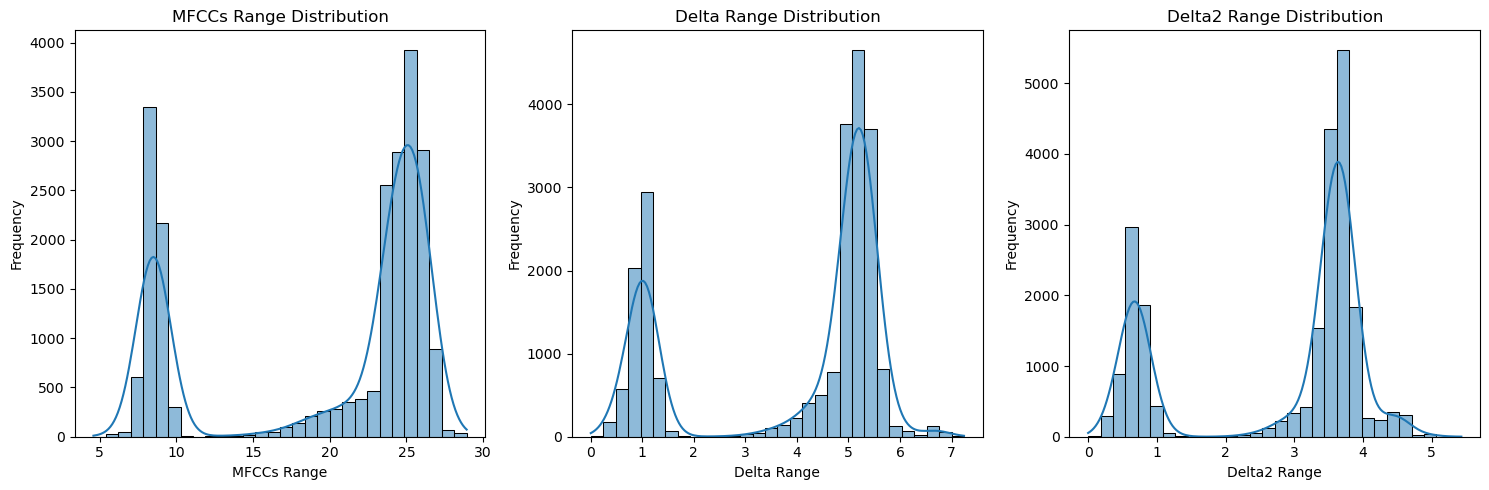

In [100]:
# Calculate the range for MFCCs, delta, and delta2 features
mfccs_df['mfccs_range'] = mfccs_df['mfccs_max'] - mfccs_df['mfccs_min']
mfccs_df['delta_range'] = mfccs_df['delta_max'] - mfccs_df['delta_min']
mfccs_df['delta2_range'] = mfccs_df['delta2_max'] - mfccs_df['delta2_min']

# Visualization
fig, axes = plt.subplots(ncols = 3, figsize=(15, 5))

# MFCCs Range

sns.histplot(mfccs_df['mfccs_range'], bins=30, kde=True, ax = axes[0]).set(
    title = 'MFCCs Range Distribution',
    xlabel = 'MFCCs Range',
    ylabel = 'Frequency'
)

# Delta Range

sns.histplot(mfccs_df['delta_range'], bins=30, kde=True, ax = axes[1]).set(
    title = 'Delta Range Distribution',
    xlabel = 'Delta Range',
    ylabel = 'Frequency'
)

# Delta2 Range

sns.histplot(mfccs_df['delta2_range'], bins=30, kde=True, ax = axes[2]).set(
    title = 'Delta2 Range Distribution',
    xlabel = 'Delta2 Range',
    ylabel = 'Frequency'

)
plt.tight_layout()
plt.show()


- MFCCs Range Distribution: The distribution of the MFCCs range shows a wide variation, indicating that the acoustic properties captured by the MFCCs differ significantly across the sounds in the dataset.


- Delta Range Distribution: The range for the deltas also shows variability, reflecting the changes in the MFCCs over time. This suggests a diversity in the rate and manner in which the acoustic properties change across different sounds.


- Delta2 Range Distribution: Similarly, the delta2 range distribution shows variation, indicating differences in the acceleration of changes in the acoustic properties captured by the MFCCs.

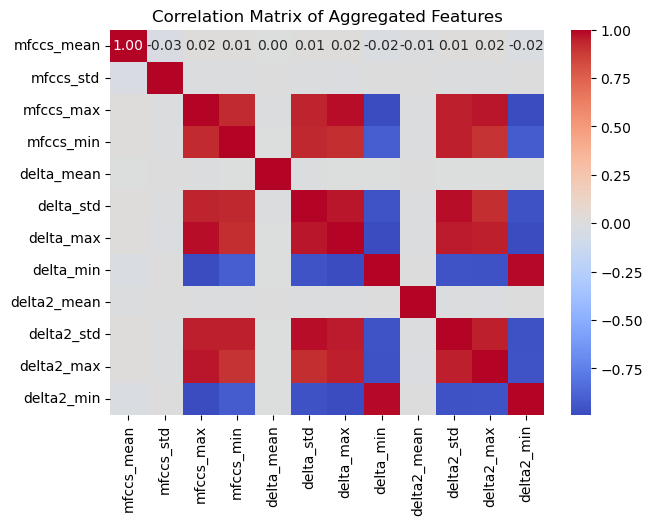

In [189]:
# Calculate correlation matrix among aggregated features
aggregated_features =['mfccs_mean', 'mfccs_std', 'mfccs_max', 'mfccs_min', 
                      'delta_mean', 'delta_std', 'delta_max', 'delta_min', 
                      'delta2_mean', 'delta2_std', 'delta2_max','delta2_min']

aggregated_features_correlation = mfccs_df[aggregated_features].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(aggregated_features_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Aggregated Features')
plt.show()


## Distribution of Delta Mean

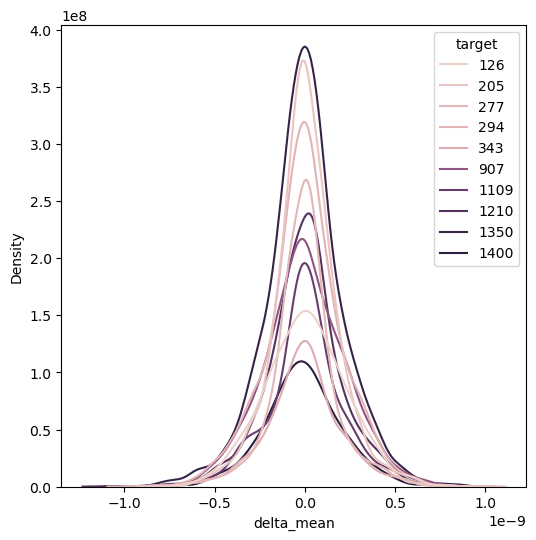

In [194]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 6))

sns.kdeplot(mfccs_df, x = 'delta_mean', hue = 'target', ax = axes);

In [149]:
for i in range(len(targets)):
    person = mfccs_df[mfccs_df['target'] == targets[i]]['delta_mean']
    kurt = kurtosis(person, axis=0, bias=True)
    print(f'Kurtosis {targets[i]}: {kurt}')

Kurtosis 343: 1.0620009973521025
Kurtosis 1210: 1.5164933095577435
Kurtosis 1109: 1.3394070170062005
Kurtosis 1350: 1.2500196136514
Kurtosis 1400: 0.7000728650818484
Kurtosis 205: 1.4635417972571716
Kurtosis 294: 0.7113687457641462
Kurtosis 277: 2.9117129882491213
Kurtosis 126: 0.13173513258174818
Kurtosis 907: 0.2643837209679889


__Variability Among Individuals:__ The variation in kurtosis values among the individuals highlights differences in the distribution of their sound characteristics. Those with higher kurtosis values (e.g., Kurtosis277) have more pronounced outliers in their mfccs_mean distribution. This could suggest a greater variability in how they produce sound, or it might reflect a wider range of vocal expressions captured in the dataset for these individuals.

## Visualizing Principal Components

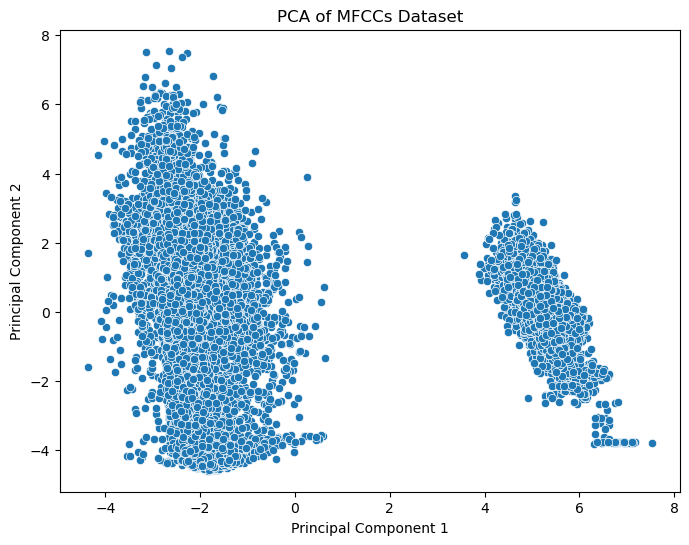

In [200]:
numeric_features = mfccs_df.columns[4:].tolist()  

X = StandardScaler().fit_transform(mfccs_df[numeric_features])


pca = PCA(n_components=2) 
principal_components = pca.fit_transform(X)
principal_df = pd.DataFrame(data=principal_components,
                            columns=['Principal Component 1', 'Principal Component 2'])
# principal_df['target'] = mfccs_df['target']


plt.figure(figsize=(8, 6))
sns.scatterplot(data = principal_df, x='Principal Component 1', y='Principal Component 2')
plt.title('PCA of MFCCs Dataset')
plt.show()


__Distinct Vocal Characteristics__: The presence of two distinct clusters suggests there are at least two groups of individuals with significantly different vocal characteristics captured by the MFCCs and their aggregated features. These differences might be due to a variety of factors, including but not limited to physiological differences, speaking styles, emotional expression, or even recording conditions.

In [178]:
from sklearn.manifold import TSNE

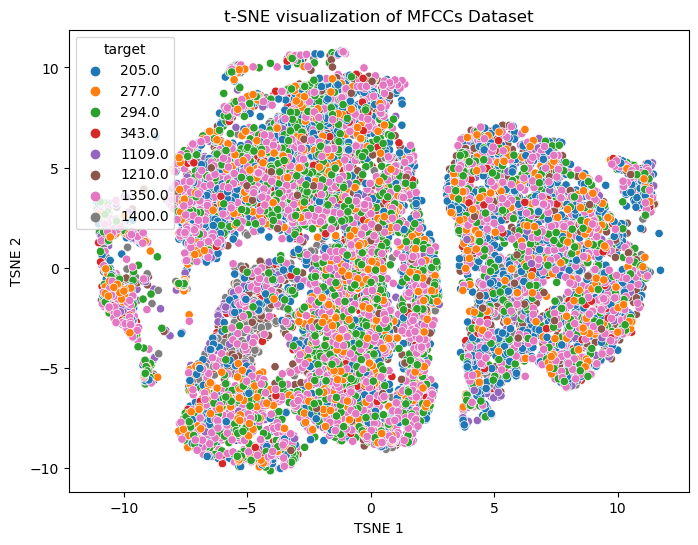

In [185]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(X)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE 1', 'TSNE 2'])
tsne_df['target'] = mfccs_df['target']  # Your target variable

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE 1', y='TSNE 2', hue='target', data=tsne_df, palette="tab10", legend="full")
plt.title('t-SNE visualization of MFCCs Dataset')
plt.show()
